### Using a Variational Auto-encoder to predict protein fitness from evolutionary data

July 20, 2017
### Sam Sinai and Eric Kelsic


## For the blog post associated with this notebook see [this post](https://samsinai.github.io/jekyll/update/2017/08/14/Using-a-Variational-Autoencoder-to-predict-protein-function.html). 


This notebook it organized in 3 sections. In section 1 we show our workflow for pre-processing the biological data. We then train the model on the alignment data in section 2. In section 3 we compare the predictions of the model on the [PABP yeast](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3851721/) dataset. In section 4 we report the results from analyzing multiple other datasets. Finally we pose some questions with regards to improving the model for interested researcher.

In [1]:
import sys

sys.executable

'/usr/bin/python3'

In [1]:
# !/usr/bin/python3 -m pip install Bio
# !/usr/bin/python3 -m pip install biopython
# !/usr/bin/python3 -m pip install umap
# !/usr/bin/python3 -m pip install torch

In [2]:
# Generic imports
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math,random,re
import time
from sklearn.decomposition import PCA

from Bio import SeqIO

In [3]:
#Machine learning/Stats imports 
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as D

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

In [5]:
from models import *

In [6]:
import umap

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.  Data pre-processing

Defining the alphabet that is used for Amino-Acids throughout.

These are helper functions to clean and process data. 

In [8]:
%reload_ext autoreload
%autoreload 1
from helper_tools import *
from helper_tools_for_plotting import *

Import the alignment data:

In [9]:
sarkisyan=pd.read_csv("sarkisyan.csv")

In [10]:
seqs = []
for record in SeqIO.parse("aligned_gfp.fasta", "fasta"):
    seqs.append("".join(record.seq))

seqs.append(seqs[0])

data = pd.DataFrame({"sequence": seqs})

In [11]:
seq_uniprot = []
for record in SeqIO.parse("aligned_gfp_uniprot.fasta", "fasta"):
    seq_uniprot.append("".join(record.seq))

data_uniprot = pd.DataFrame({"sequence": seq_uniprot})

In [12]:
seq_together = seqs.copy()
for record in SeqIO.parse("aligned_gfp_uniprot.fasta", "fasta"):
    seq_together.append("".join(record.seq))

data_together = pd.DataFrame({"sequence": seq_together})

In [13]:
data = data_together.copy()

In [14]:
data.iloc[0]["sequence"]

'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLT--VQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'

Let's see how long the sequence is

In [15]:
print ("length of sequence:", len(data.iloc[0]["sequence"]))#, len(data.iloc[0]["seq"]))
print ("sample sequence: ", data.iloc[0]["sequence"])

length of sequence: 238
sample sequence:  MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLT--VQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK


We are only really interested in the columns that do align. This means that for every column that we include, at least 50% of sequences are not gaps. Note that this threshold is imposed by the alignment parameters loaded above. So let's make a column for that. Meanwhile, we keep track of the indices that did align.

In [16]:
indices=index_of_non_lower_case_dot(data.iloc[0]["sequence"])
data["seq"]=list(map(prune_seq,data["sequence"]))
data.head()

,sequence,seq
0,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
1,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
2,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
3,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...
4,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...


Let's see how many columns remained. 

In [17]:
print ("pruned sequence length:", len(data.iloc[0]["seq"]))
PRUNED_SEQ_LENGTH=len(data.iloc[0]["seq"])

pruned sequence length: 238


In [18]:
uniquechars = set()
for i in data['seq']:
    uniquechars = uniquechars.union(i)

In [19]:
#Invariants
# ORDER_KEY="XILVAGMFYWEDQNHCRKSTPBZ-"[::-1]
# ORDER_LIST=list(ORDER_KEY)
ORDER_LIST = list(uniquechars)
ORDER_LIST = sorted(ORDER_LIST,reverse=True)

A few optional lines of code to run. Printing indices, and deleting the sequence column so that it doesn't stay in memory for no reason. 

Next we translate the sequence into a one hot encoding and shape the input sequences into a m*n matrix. Here m is the number of the data points and $n=$ alphbet size $\times$ sequence length.

In [20]:
#Encode Orthologs
training_data_one_hot=[]
labels=[]
for i, row in data.iterrows():
    training_data_one_hot.append(translate_string_to_one_hot(row["seq"],ORDER_LIST))
print (len(training_data_one_hot),len(training_data_one_hot[0]),len(training_data_one_hot[0][0]))
#plt.imshow(training_data_one_hot[0],cmap="Greys")
training_data=np.array([np.array(list(sample.T.flatten())) for sample in training_data_one_hot])
# training_data=np.array([np.array(list(sample.flatten())).T for sample in training_data_one_hot])
print(training_data.shape)

882 23 238
(882, 5474)


In [21]:
#Encode sarkisyan data to one hot
sarkisyan_data_one_hot=[]
labels=[]
for i, row in sarkisyan.iterrows():
    sarkisyan_data_one_hot.append(translate_string_to_one_hot(row["sequence"],ORDER_LIST))
print (len(sarkisyan_data_one_hot),len(sarkisyan_data_one_hot[0]),len(sarkisyan_data_one_hot[0][0]))
#plt.imshow(training_data_one_hot[0],cmap="Greys")
sarkisyan_data=np.array([np.array(list(sample.T.flatten())) for sample in sarkisyan_data_one_hot])
# training_data=np.array([np.array(list(sample.flatten())).T for sample in training_data_one_hot])
print(sarkisyan_data.shape)

51715 23 238
(51715, 5474)


## Basic Functions

In [22]:
def build_PCA(data, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    return pca

def feed_PCA(pca, data):
    return pca.transform(data)

def split_data(xdata, ydata, train_size):
    x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, train_size=train_size, random_state=10)
    return (x_train, x_test, y_train, y_test)

def train_test(x_train, x_test, y_train, y_test, model_type="reg"):
    if (model_type == "reg"):
        reg = RandomForestRegressor()
        reg.fit(x_train, y_train)
        return (reg.score(x_test, y_test))
    
    elif (model_type == "clf"):
        clf = RandomForestClassifier()
        clf.fit(x_train, y_train > 0.5)
        return (clf.score(x_test, y_test > 0.5))
    
    return None    

def augmented_learning(data, additional_data, labels, n_components, train_size):
    x_train, x_test, y_train, y_test = split_data(data, labels, train_size=train_size)
    
    augmented_data = np.concatenate([x_train, additional_data])
    pca = build_PCA(augmented_data, n_components=n_components)
    transformed_train = feed_PCA(pca, x_train)
    transformed_test = feed_PCA(pca, x_test)

    
    reg_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="reg")
    clf_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="clf")
    
    return (reg_score, clf_score)

def normal_learning(data, labels, train_size):
    x_train, x_test, y_train, y_test = split_data(data, labels, train_size=train_size)

    reg_score = train_test(x_train, x_test, y_train, y_test, model_type="reg")
    clf_score = train_test(x_train, x_test, y_train, y_test, model_type="clf")
    
    return (reg_score, clf_score)

## Baseline One-hot model 

In [ ]:
accuracies = normal_learning(sarkisyan_data, sarkisyan['quantitative_function'], train_size=0.7)

In [ ]:
accuracies[0]

In [34]:
accuracies[1]

0.9221398646471157

## PCA models

In [25]:
def PCA_test(max_components):
    pca = PCA(n_components=max_components)
    pca.fit(training_data)
    pca_sarkisyan = pca.transform(sarkisyan_data)
    
    clf_scores = []
    reg_scores = []
    for i in range(max_components):
        cut_sarkisyan = pca_sarkisyan[:, 0:i+1]
        
        #Classification on training data
        sarkisyan['function'] = sarkisyan['quantitative_function'] > 0.5
        X_train, X_test, y_train, y_test = train_test_split(cut_sarkisyan, sarkisyan['function'], 
                                                           test_size = 0.3, random_state=10)

        naiveClf = RandomForestClassifier()
        naiveClf.fit(X_train, y_train)
        clf_score = naiveClf.score(X_test, y_test)

        X_train, X_test, y_train, y_test = train_test_split(cut_sarkisyan, sarkisyan['quantitative_function'], 
                                                       test_size = 0.3, random_state=10)
        naiveReg = RandomForestRegressor()
        naiveReg.fit(X_train, y_train)
        reg_score = naiveReg.score(X_test, y_test)

        clf_scores.append(clf_score)
        reg_scores.append(reg_score)
        
    return (clf_scores, reg_scores)

In [26]:
pca_scores = PCA_test(20)

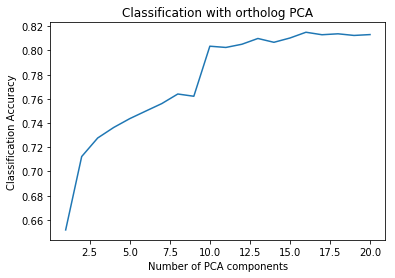

In [27]:
plt.plot(range(1, 21), np.array(pca_scores)[0])
plt.xlabel("Number of PCA components")
plt.ylabel("Classification Accuracy")
plt.title("Classification with ortholog PCA")
plt.savefig("Ortholog_PCA_on_Sarkisyan.png")
plt.show()

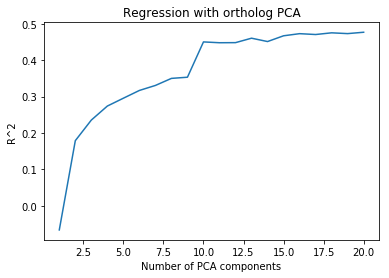

In [28]:
plt.plot(range(1, 21), np.array(pca_scores)[1])
plt.xlabel("Number of PCA components")
plt.ylabel("R^2")
plt.title("Regression with ortholog PCA")
plt.savefig("Ortholog_PCA_on_Sarkisyan_regression.png")
plt.show()

## Data-Augmentation in low-data settings

In [29]:
training_sizes = [100, 300, 500, 1000, 2000, 5000]

reg_score_normal = []
reg_score_augmented = []
clf_score_normal = []
clf_score_augmented = []

for size in training_sizes:
    aug_run = augmented_learning(sarkisyan_data, sarkisyan_data[:1000], sarkisyan['quantitative_function'], 10, size)
    normal_run = normal_learning(sarkisyan_data, sarkisyan['quantitative_function'], size)
    reg_score_normal.append(normal_run[0])
    reg_score_augmented.append(aug_run[0])
    clf_score_normal.append(normal_run[1])
    clf_score_augmented.append(aug_run[1])

KeyboardInterrupt: 

In [ ]:
plt.scatter(training_sizes, reg_score_normal, label="One-hot")
plt.scatter(training_sizes, reg_score_augmented, label="PCA Augmented")
plt.xlabel("Training size")
plt.title("PCA = 10, Regression Accuracy")
plt.legend()
plt.savefig("PCA_10_Reg.png")
plt.show()

In [23]:
sarkisyan_onehot_train, sarkisyan_onehot_test, y_train, y_test = train_test_split(sarkisyan_data, sarkisyan['quantitative_function'], 
                                                   test_size = 0.99, random_state=10)

In [24]:
augmented_data = np.concatenate((training_data, sarkisyan_onehot_train))

In [25]:
augment_pca = PCA(n_components=20)
augment_pca.fit(augmented_data)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [26]:
transformed_train = augment_pca.transform(sarkisyan_onehot_train)
transformed_test = augment_pca.transform(sarkisyan_onehot_test)

In [34]:
augClf = RandomForestClassifier()
augClf.fit(transformed_train, y_train>0.5)
augClf.score(transformed_test, y_test>0.5)

0.7448923786085394

In [35]:
augReg = RandomForestRegressor()
augReg.fit(transformed_train, y_train)
augReg.score(transformed_test, y_test)

0.2870077861073814

In [ ]:
net = Reg_NN(input_size = 20, hidden_size=100, output_size=1)

In [ ]:
transformed_train.shape

In [46]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss


for t in range(200):
    prediction = net(torch.Tensor(transformed_train))     # input x and predict based on x

    loss = loss_func(prediction, torch.Tensor(np.array(y_train)))     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
#     print (net.parameters())

In [47]:
out_train = net(torch.Tensor(transformed_train))
out_train = torch.Tensor(out_train)

In [48]:
from sklearn.metrics import r2_score

In [49]:
r2_score(out_train.squeeze(1).detach(), y_train)

-7425.0913027948345

In [50]:
training_data[0].shape

(5474,)

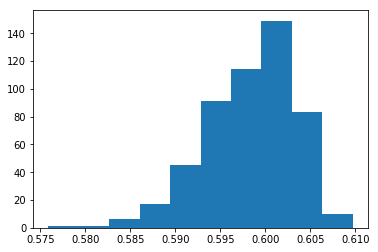

In [51]:
plt.hist(out_train.squeeze(1).detach())
plt.show()

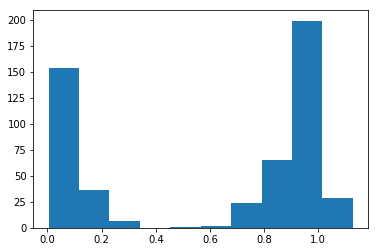

In [52]:
plt.hist(y_train)
plt.show()

## UMAP Experiments

In [ ]:
UMAP_embedding = umap.UMAP(n_neighbors=3,
                      min_dist=0.05,
                      metric='manhattan').fit(training_data)

In [550]:
a = UMAP_embedding.transform(training_data)

In [551]:
a

array([[ 6.649287 ,  9.458338 ],
       [ 7.1583214, -2.633993 ],
       [-8.284651 , -3.4905474],
       ...,
       [ 9.465265 , -6.686657 ],
       [ 9.704497 , -5.273012 ],
       [ 4.786226 , -6.1747694]], dtype=float32)

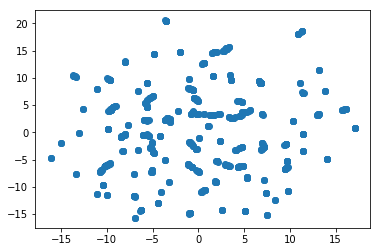

In [552]:
plt.scatter(a[:, 0], a[:, 1])
plt.show()

In [553]:
UMAP_sarkisyan = UMAP_embedding.transform(sarkisyan_data)

In [554]:
# UMAP_sarkisyan = UMAP_embedding.transform(sarkisyan_data)

X_train, X_test, y_train, y_test = train_test_split(UMAP_sarkisyan, sarkisyan['function'], 
                                                   test_size = 0.3, random_state=10)

naiveClf = RandomForestClassifier()
naiveClf.fit(X_train, y_train)
clf_score = naiveClf.score(X_test, y_test)

X_train, X_test, y_train, y_test = train_test_split(UMAP_sarkisyan, sarkisyan['quantitative_function'], 
                                               test_size = 0.3, random_state=10)
naiveReg = RandomForestRegressor()
naiveReg.fit(X_train, y_train)
reg_score = naiveReg.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [555]:
clf_score

0.5135030615533355

In [556]:
reg_score

-0.24899542340754088

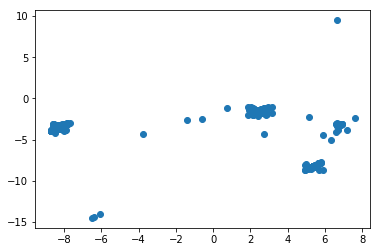

In [558]:
plt.scatter(UMAP_sarkisyan[:,0][:10000], UMAP_sarkisyan[:, 1][:10000])
plt.show()

In [548]:
UMAP_sarkisyan_20 = UMAP_sarkisyan.copy()
ortholog_umap_20 = a.copy()

This concludes the pre-processing we need to do on the data.

## 2.  Training the model
We now move on to define our neural network. This is essentially a vanilla VAE in keras (with some optimization on hyperparameters). For optimization purposes we define a callback function that reports the predictive power of the model in the end of each epoch. Note that while this passes the -test data- through the model, it is kosher because we never pass in the values we are actually interested in and the network is not in "training phase", i.e. no weights are updated during this pass. 

In [27]:
class rho_vs_mutants():
    def __init__(self,mutants,test_set_size,aa_size,sequence_size):
        self.mutants=mutants
        self.sample_size=test_set_size
        self.aa_size=aa_size
        self.sequence_size=sequence_size
        self.scores=[]
        self.count_batch=0
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    #This allows us to track the "progress" of the model on different epochs
    def on_epoch_end(self,model,batch,logs):
        x_decoded=model(test_data_plus[0:self.sample_size],batch_size=batch_size)
        digit = x_decoded[0].reshape(self.aa_size,self.sequence_size)
        digit_wt = normalize(digit,axis=0, norm='l1')
        wt_prob=compute_log_probability(digit,digit_wt)
        fitnesses=[]
        for sample in range(1,self.sample_size):
            digit = x_decoded[sample].reshape(self.aa_size,self.sequence_size)
            digit = normalize(digit,axis=0, norm='l1')
            fitness=compute_log_probability(test_data_plus[sample].reshape(self.aa_size,self.sequence_size),digit)-wt_prob
            fitnesses.append(fitness)
        print (","+str(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])))
        self.scores.append(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])[0])

Now we are ready to specify the network architecture, this is adapted from [here](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py).

In [28]:
# torch.sum(1 + model.z_log_var - (model.z_mean)**2 - torch.exp(model.z_log_var),-1)

In [29]:
PRUNED_SEQ_LENGTH

238

In [30]:
batch_size = 24
original_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
output_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
latent_dim = 2
intermediate_dim=30
nb_epoch = 20
epsilon_std = 1.0
np.random.seed(42)  

loss1 = nn.CrossEntropyLoss()

def vae_loss(x_true, x_decoded_mean, z_mean, z_log_var):
    xent_loss = original_dim * loss1(x_decoded_mean, x_true)
    kl_loss = -0.5 * torch.sum(1 + z_log_var - (z_mean)**2 - torch.exp(z_log_var))
#     print ("xent loss: ", xent_loss)
#     print ("KL loss: ", kl_loss)
    return (xent_loss + kl_loss)

And run it through our training data.

In [31]:
len(range(0, 300)[:20])

20

In [32]:
len(training_data)

882

In [33]:
training_size = 880 #so batchingw orks
x_train=training_data[:training_size] #this needs to be divisible by batch size and less than or equal to dataset size
x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))


In [51]:
vae_type = 'conv'

In [52]:
if vae_type == 'rec':
    def vae_loss(x_true, x_decoded_mean, z_mean, z_log_var):
        xent_loss = x_true.shape[0]*loss1(x_decoded_mean, x_true)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - (z_mean)**2 - torch.exp(z_log_var))
        return (xent_loss + kl_loss), xent_loss, kl_loss

In [53]:
def conv_size_func(Lin,dilation,kernel,padding=0,stride=1):
  return int(((Lin+2*padding-dilation*(kernel-1)-1)/stride)+1)

In [54]:
if vae_type == 'full':
    print ("training on full")
    univ_dropout = [0.2]*3
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout

    layers_enc = nn.ModuleList([nn.Linear(original_dim,intermediate_dim),nn.Dropout(dropout_enc[0]),nn.ELU()])
    for i in range(2):
        layers_enc.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_enc.append(nn.Dropout(dropout_enc[i+1]))
        layers_enc.append(nn.ELU())

    layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),nn.Dropout(dropout_dec[0]),nn.ELU()])
    for i in range(2):
        layers_dec.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_dec.append(nn.Dropout(dropout_dec[i+1]))
        layers_dec.append(nn.ELU())

    layers_dec.append(nn.Linear(intermediate_dim,output_dim))

    layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
elif vae_type == 'conv':
    out_conv_enc = [50,100]
    kernels_enc = [3,5]
    dilations_enc = [1,3]
    maxpools_enc = [4,3]
    paddings_enc = [(5,5,0,0)]
    
    out_lin_enc = [100,500]
    dropout_enc = [0.2,0.2]
    
    out_lin_dec = [100,150]
    dropout_dec = [0.2,0.2]
    
    layers_enc_pre_view = nn.ModuleList([nn.Conv1d(len(ORDER_LIST),out_conv_enc[0],kernels_enc[0],stride=1,dilation=dilations_enc[0]),
                                nn.ELU(),
                                nn.MaxPool1d(maxpools_enc[0],padding=0),
                                nn.ZeroPad2d(paddings_enc[0]),
                                nn.Conv1d(out_conv_enc[0],out_conv_enc[1],kernels_enc[1],stride=1,dilation=dilations_enc[1]),
                                nn.ELU(),
#                                 nn.MaxPool1d(4,padding=0),
#                                 nn.ZeroPad2d((5,5,0,0)),
#                                 nn.Conv1d(out_conv_enc[1],out_conv_enc[2],kernels_enc[2],stride=1,dilation=dilations_enc[2]),
#                                 nn.ELU(),
                                nn.MaxPool1d(maxpools_enc[1],padding=0)])
    
    inp_len = PRUNED_SEQ_LENGTH
    paddings_enc.append((0,0,0,0))
    for i in range(len(out_conv_enc)):
      inp_len = conv_size_func(inp_len,dilations_enc[i],kernels_enc[i])
      inp_len = inp_len//maxpools_enc[i]
      inp_len += (paddings_enc[i][0]+paddings_enc[i][1])
    
    enc_view = inp_len*out_conv_enc[-1]
    print('post-convolutional size is ', enc_view)
    
    layers_enc_post_view = nn.ModuleList([nn.Linear(enc_view,out_lin_enc[0]),
                                          nn.Dropout(dropout_enc[0]),
                                          nn.ELU(),
                                          nn.Linear(out_lin_enc[0],out_lin_enc[1]),
                                          nn.Dropout(dropout_enc[1]),
                                          nn.ELU()])
    
    layers_dec = nn.ModuleList([nn.Linear(latent_dim,out_lin_dec[0]),
                                nn.Dropout(dropout_dec[0]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[0],out_lin_dec[1]),
                                nn.Dropout(dropout_dec[1]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[1],output_dim)])
    
    layers_ae = nn.ModuleList([nn.Linear(out_lin_enc[-1],latent_dim),nn.Linear(out_lin_enc[-1],latent_dim)])
elif vae_type == 'rec':
    univ_dropout = [0.2]*2
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout
    hid_size = [20,10]
    dec_lin = False
    
    num_layers = 2
    num_layers_dec = 2
    bid = True
    num_dirs = 2 if bid else 1
    
   
    layers_enc = nn.ModuleList([nn.RNN(len(ORDER_LIST),hid_size[0],num_layers=num_layers,batch_first=True,dropout=univ_dropout[0],bidirectional=bid)])


    if dec_lin:
      layers_post_rec_enc = nn.ModuleList([nn.Linear(164,intermediate_dim),
                                         nn.Dropout(dropout_enc[0]),
                                         nn.ELU(),
                                         nn.Linear(intermediate_dim,intermediate_dim),
                                         nn.Dropout(dropout_enc[1]),
                                         nn.ELU()]) # for now, not being used in rec model


  #     layers_pre_rec_dec = nn.ModuleList([nn.Linear(latent_dim,100),
  #                                         nn.Dropout(dropout_dec[0]),
  #                                         nn.ELU()])
  #     # 25 below bc bidirectional 2 layers means we have to divide 100 by 2*2
  #     layers_dec = nn.ModuleList([nn.RNN(50,25,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)])
  #     layers_post_rec_dec = nn.ModuleList([nn.Linear(25*2,len(ORDER_LIST))])

  #     layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
      layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),
                                  nn.Dropout(.2),
                                  nn.ELU(),
                                  nn.Linear(intermediate_dim,intermediate_dim*2),
                                  nn.Dropout(.2),
                                  nn.ELU(),
                                  nn.Linear(intermediate_dim*2,output_dim)])
      
      layers_dec_post_rec = 0
    
      layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
    
    else: # dec_lin = False
      layers_post_rec_enc = 0
      
      layers_dec = nn.ModuleList([nn.Linear(latent_dim,hid_size[1]),nn.RNN(len(ORDER_LIST),hid_size[1],num_layers=num_layers_dec,batch_first=True,dropout=univ_dropout[1],bidirectional=bid)])
      
      layers_dec_post_rec = nn.ModuleList([nn.Linear(hid_size[1]*num_dirs,len(ORDER_LIST))])
      
      layers_ae = nn.ModuleList([nn.Linear(hid_size[0],latent_dim),nn.Linear(hid_size[0],latent_dim)])
      
      

post-convolutional size is  1900


In [55]:
losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []
xents_train = []
xents_test = []
kls_train = []
kls_test = []

if vae_type == 'full':
    print ("training full")
    model = VAE(layers_enc,layers_ae,layers_dec)

    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,len(ORDER_LIST)*PRUNED_SEQ_LENGTH) # 1968)

        train = torch.Tensor(train)

        
        
        for batch in train:
            out = model(batch)

            batch = batch.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)
            
            optimizer.zero_grad()
            loss.backward()  
            optimizer.step()
            
        model.eval()

        out_train = model(torch.Tensor(x_train_data))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
        
        losses_train.append(loss_train)
        losses_test.append(loss_val)
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

elif vae_type == 'conv':
    print ("conv")
    model = VAE_conv(layers_enc_pre_view,enc_view,layers_enc_post_view,layers_ae,layers_dec)
        
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = torch.Tensor(train)
        train = train.transpose(-2,-1)

        for batch in train:
            out = model(batch)

            batch = batch.transpose(-2,-1).reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
                            
            loss = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        losses_train.append(loss_train)
        losses_test.append(loss_val)
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
        
elif vae_type == 'rec':
    print ("rec")
    if lang_mod:
        print("language model training")
    else:
        print("vae training")
    
    alpha = 50000
    beta = 0.005
    print('KL annealing terms: alpha = {}, beta = {}'.format(alpha,beta))
        
    model = VAE_rec(layers_enc,layers_post_rec_enc,layers_ae,0,layers_dec,layers_dec_post_rec)
    
    if cuda:
        model = model.cuda()
    
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.01)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)
    
#     print('FAKE TRAINING SET TO ASSESS REC VALIDITY')
#     x_train_data = np.array([[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*3690000).reshape(45000,1968)
    
#     import pdb; pdb.set_trace()
    
    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)
    
    ins_train = create_tensor(ins_train,gpu=cuda)
    ins_val = create_tensor(ins_val,gpu=cuda)
    
    
    ## Printing model perf before
    model.eval()
            
    out_train = model(create_tensor(torch.Tensor(x_train_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
    out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

    classpreds_train = torch.argmax(out_train,dim=1)
    bool_train = (classpreds_train==ins_train)
    class_acc_train = bool_train.sum().item()/bool_train.shape[0]

    out_val = model(create_tensor(torch.Tensor(x_val_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
    out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

    classpreds_val = torch.argmax(out_val,dim=1)
    bool_val = (classpreds_val==ins_val)
    class_acc_val = bool_val.sum().item()/bool_val.shape[0]

    loss_train,xent_train,kl_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
    kl_train = sigmoid(beta*(-alpha))*kl_train # annealing
    loss_train = xent_train + kl_train # annealing
    loss_val,xent_val,kl_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
    kl_val = sigmoid(beta*(-alpha))*kl_val # annealing
    loss_val = xent_val + kl_val # annealing

    losses_train.append(loss_train.item())
    losses_test.append(loss_val.item())
    accuracies_train.append(class_acc_train)
    accuracies_test.append(class_acc_val)
    xents_train.append(xent_train.item())
    xents_test.append(xent_val.item())
    kls_train.append(kl_train.item())
    kls_test.append(kl_val.item())

    print('Pre-training | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
          %( loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
    
    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = create_tensor(torch.Tensor(train),gpu=cuda)

        xents = []
        kls = []
        
        num_dum = -1

        optimizer.zero_grad()
        
        for batch in train:
            num_dum += 1
            out = model(batch,True,lang_mod)
            
#             import pdb; pdb.set_trace()
            batch = torch.argmax(batch,-1)
            batch = batch.reshape(-1)
                        
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss,xent,kl = vae_loss(batch,out,model.z_mean,model.z_log_var)
            mult = epoch*len(x_train_data)/batch_size + num_dum # annealing
            kl = sigmoid(beta*(mult-alpha))*kl # annealing
            loss = xent + kl # annealing
            if num_dum % 1000 == 0:
                print((batch==torch.argmax(out,-1)).sum().item()/(batch_size*PRUNED_SEQ_LENGTH*1.0))
            xents.append(xent)
            kls.append(kl)

            if lang_mod:
                xent.backward()
            else:
                loss.backward()   
            
#         for layer, paramval in model.named_parameters():
#             print(layer,paramval.grad)
            
        optimizer.step()
            
#         import pdb; pdb.set_trace()
        print('xent mean is:',torch.stack(xents).mean().item())
        print('kl mean is:',torch.stack(kls).mean().item())

        model.eval()
        
#         import pdb; pdb.set_trace()
        out_train = model(create_tensor(torch.Tensor(x_train_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(create_tensor(torch.Tensor(x_val_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train,xent_train,kl_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        mult = epoch*len(x_train_data)/batch_size + num_dum # annealing
        kl_train = sigmoid(beta*(mult-alpha))*kl_train # annealing
        loss_train = xent_train + kl_train # annealing
        loss_val,xent_val,kl_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
        kl_val = sigmoid(beta*(mult-alpha))*kl_val # annealing
        loss_val = xent_val + kl_val # annealing
        
        losses_train.append(loss_train.item())
        losses_test.append(loss_val.item())
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        xents_train.append(xent_train.item())
        xents_test.append(xent_val.item())
        kls_train.append(kl_train.item())
        kls_test.append(kl_val.item())
        
        print(classpreds_train)
        print(classpreds_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

conv
Epoch 0 | Training Loss: 7033.587890625, Training Accuracy: 0.6430587386469739, Validation Loss: 7373.68896484375, Validation Accuracy: 0.636220397249809
Epoch 1 | Training Loss: 4786.1474609375, Training Accuracy: 0.7767751039809864, Validation Loss: 5206.70703125, Validation Accuracy: 0.76188884644767
Epoch 2 | Training Loss: 4392.765625, Training Accuracy: 0.7916030048382989, Validation Loss: 4800.09228515625, Validation Accuracy: 0.7745416348357524
Epoch 3 | Training Loss: 4152.19775390625, Training Accuracy: 0.7960328070622188, Validation Loss: 4530.43310546875, Validation Accuracy: 0.7786955691367456
Epoch 4 | Training Loss: 4121.8056640625, Training Accuracy: 0.7960805534334946, Validation Loss: 4490.16943359375, Validation Accuracy: 0.7815126050420168
Epoch 5 | Training Loss: 3922.9150390625, Training Accuracy: 0.801274297597827, Validation Loss: 4283.8662109375, Validation Accuracy: 0.7847593582887701
Epoch 6 | Training Loss: 3854.48681640625, Training Accuracy: 0.8089508

Let's explore the latent space

In [56]:
if vae_type == 'full':
    fit_xtrain = model(torch.Tensor(x_train)).detach()
    z_means = model.z_mean.detach()
elif vae_type == 'conv':
    fit_xtrain = model(torch.Tensor(x_train.reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST))).transpose(1,2)).detach()
    z_means = model.z_mean.detach()

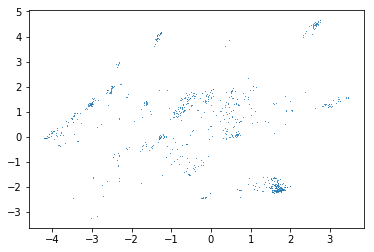

In [57]:
transposed_zmeans = np.array(z_means).transpose()

plt.scatter(transposed_zmeans[0], transposed_zmeans[1], s = 1, linewidths = 0)
plt.show()

In [58]:
from sklearn.cluster import KMeans

z_means_np = np.array(z_means)
kmeans = KMeans(n_clusters=12, random_state=1).fit(z_means_np)

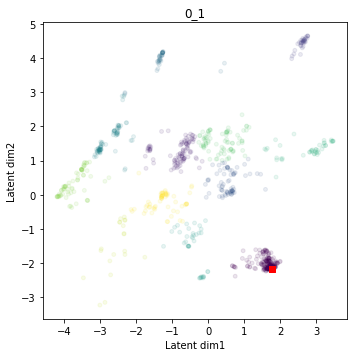

In [59]:
sample_points=len(z_means_np)

latent_dim = 2
fig = plt.figure(figsize=(12,12))
counter=0
cmap=kmeans.labels_
for z1 in range(latent_dim):
    for z2 in range(z1+1,latent_dim):
        counter+=1
        fig.add_subplot(latent_dim,latent_dim,counter)
        plt.title(str(z1)+"_"+str(z2))
        plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c=cmap[::-1], s = 15, alpha=0.1,marker="o")
#         plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c="y" ,alpha=0.3,marker="o")
        plt.scatter(z_means_np[0][z1], z_means_np[0][z2],c="r" ,alpha=1,s=40,marker="s")
        plt.xlabel("Latent dim"+str(z1+1))
        plt.ylabel("Latent dim"+str(z2+1));
plt.savefig("Try2_originalDropout.png")


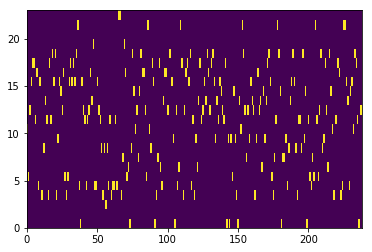

In [60]:
plt.pcolor(x_train[0].reshape(PRUNED_SEQ_LENGTH, len(ORDER_LIST)).transpose(1, 0))
plt.show()

# Training a classifier over the latent space

In [61]:
if vae_type == 'full':
    fit_total = model(torch.Tensor(sarkisyan_data)).detach()
    latent_data = model.z_mean.detach()
elif vae_type == 'conv':
    fit_total = model(torch.Tensor(sarkisyan_data.reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST))).transpose(1,2)).detach()
    latent_data = model.z_mean.detach()

RuntimeError: $ Torch: not enough memory: you tried to allocate 2GB. Buy new RAM! at /pytorch/aten/src/TH/THGeneral.cpp:201

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(latent_data), sarkisyan['quantitative_function'], 
                                                   test_size = 0.3, random_state=10)

In [47]:
latentReg = RandomForestRegressor()
latentReg.fit(X_train, y_train)
# latentReg.predict(X_test)
latentReg.score(X_test, y_test)

-0.12730975212407425

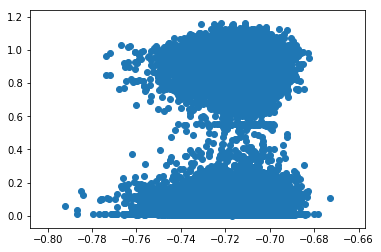

In [48]:
plt.scatter(X_train[:,0], y_train)
plt.show()

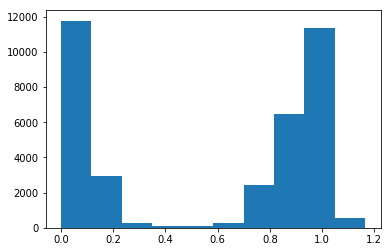

In [49]:
plt.hist(y_train)
plt.show()

In [50]:
sarkisyan['function'] = sarkisyan['quantitative_function'] > 0.5

X_train, X_test, y_train, y_test = train_test_split(np.array(latent_data), sarkisyan['function'], 
                                                   test_size = 0.3, random_state=10)

latentClf = RandomForestClassifier()
latentClf.fit(X_train, y_train)
# latentReg.predict(X_test)
latentClf.score(X_test, y_test)

0.5770544634224943

In [88]:
np.sum(sarkisyan['function'])/len(sarkisyan)

0.5817461084791646

## Calculating P(X)

In [808]:
m = torch.nn.Softmax()

In [826]:
reshaped_fit_sarkisyan = np.array(m(fit_total.reshape(51715 * 238, 24)).reshape(51715, 238, 24).transpose(2, 1))

//anaconda/envs/ML_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


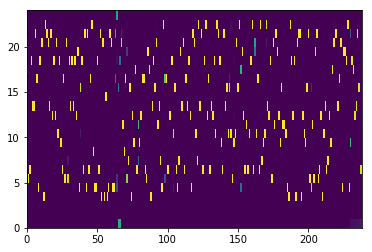

In [817]:
plt.pcolor(reshaped_fit_sarkisyan[0])

In [818]:
fit_total.shape

torch.Size([51715, 5712])

In [820]:
len(ORDER_LIST)

24

In [823]:
digit_wt

array([[2.19017694e-01, 1.76381731e-02, 2.05365546e-04, ...,
        5.06741362e-02, 4.96158629e-02, 7.01698263e-02],
       [3.84455011e-10, 1.70342977e-11, 1.67956777e-13, ...,
        3.04854793e-13, 2.42755678e-12, 2.80067300e-12],
       [6.25988012e-11, 4.45702738e-10, 2.33662843e-11, ...,
        6.18295471e-12, 2.93730308e-13, 1.39405531e-11],
       ...,
       [2.01384164e-03, 3.60576881e-11, 2.95358245e-08, ...,
        9.49057519e-01, 6.34275699e-12, 3.52582664e-12],
       [7.59836029e-11, 1.84866427e-11, 4.35174631e-11, ...,
        7.79992231e-11, 1.80350901e-11, 1.41240556e-10],
       [9.00744640e-13, 2.10846407e-11, 2.44172479e-04, ...,
        7.79476588e-10, 7.32273920e-12, 5.61766216e-13]])

In [833]:
sample_size=len(fit_total)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)

digit = reshaped_fit_sarkisyan[0]#fit_xtrain_softmax_reshaped[0]
digit_wt = digit
digit_wt = normalize(digit,axis=0, norm='l1')
# print (digit_wt)


wt_prob=compute_log_probability(reshaped_fit_sarkisyan[0].reshape(digit_size, sequence_size),digit_wt)
#print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size, sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = reshaped_fit_sarkisyan[sample]
#     print (digit)
#     print (digit_avg)
#     digit_wt_i = normalize(digit,axis=0, norm='l1')
    digit_wt_i = digit
    
#     print (digit_wt_i)
    
    digit_avg+=np.array(digit_wt_i) * 1. / sample_for_averging_size
    
    wt_p=compute_log_probability(reshaped_fit_sarkisyan[sample].reshape(digit_size, sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
    
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[] #first plug in just the sequences
fitnesses_vs_avg=[] 

for sample in range(1,sample_size):
    digit = reshaped_fit_sarkisyan[sample]
#     digit = normalize(digit,axis=0, norm='l1')
    
    fitness=compute_log_probability(reshaped_fit_sarkisyan[sample].reshape(digit_size, sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(reshaped_fit_sarkisyan[sample].reshape(digit_size, sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(reshaped_fit_sarkisyan[sample].reshape(digit_size, sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)
    
    
print ("Spearman",spearmanr(fitnesses_vs_avg,sarkisyan['quantitative_function'][:sample_size-1]))
print ("Pearson", pearsonr(fitnesses_vs_avg,sarkisyan['quantitative_function'][:sample_size-1]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses_vs_wt,sarkisyan['quantitative_function'][:sample_size-1]))
print ("Pearson", pearsonr(fitnesses_vs_wt,sarkisyan['quantitative_function'][:sample_size-1]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses,sarkisyan['quantitative_function'][:sample_size-1]))
print ("Pearson", pearsonr(fitnesses,sarkisyan['quantitative_function'][:sample_size-1]))

Spearman SpearmanrResult(correlation=0.0037379544228609103, pvalue=0.39531402980057295)
Pearson (0.006067801511975757, 0.1676357173445102)
------------------------------
Spearman SpearmanrResult(correlation=0.0037190778438605876, pvalue=0.3977049025277771)
Pearson (0.006060601648830167, 0.16814051883535286)
------------------------------
Spearman SpearmanrResult(correlation=0.0037039855461491033, pvalue=0.39962272099680085)
Pearson (0.005919161490409741, 0.17829002187402768)


In [ ]:
sample_size=len(fit_total)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)

digit = reshaped_fit_sarkisyan[0]#fit_xtrain_softmax_reshaped[0]
digit_wt = digit
digit_wt = normalize(digit,axis=0, norm='l1')
# print (digit_wt)


wt_prob=compute_log_probability(reshaped_fit_sarkisyan[0].reshape(digit_size, sequence_size),digit_wt)

wt_probs=[]
digit_avg=np.zeros((digit_size, sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = reshaped_fit_sarkisyan[sample]
#     print (digit)
#     print (digit_avg)
#     digit_wt_i = normalize(digit,axis=0, norm='l1')
    digit_wt_i = digit
    
#     print (digit_wt_i)
    
    digit_avg+=np.array(digit_wt_i) * 1. / sample_for_averging_size
    
    wt_p=compute_log_probability(reshaped_fit_sarkisyan[sample].reshape(digit_size, sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
    
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[] #first plug in just the sequences
fitnesses_vs_avg=[] 

for sample in range(1,sample_size):
    digit = reshaped_fit_sarkisyan[sample]
#     digit = normalize(digit,axis=0, norm='l1')
    
    fitness=compute_log_probability(reshaped_fit_sarkisyan[sample].reshape(digit_size, sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(reshaped_fit_sarkisyan[sample].reshape(digit_size, sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(reshaped_fit_sarkisyan[sample].reshape(digit_size, sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)
    
    
print ("Spearman",spearmanr(fitnesses_vs_avg,sarkisyan['quantitative_function'][:sample_size-1]))
print ("Pearson", pearsonr(fitnesses_vs_avg,sarkisyan['quantitative_function'][:sample_size-1]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses_vs_wt,sarkisyan['quantitative_function'][:sample_size-1]))
print ("Pearson", pearsonr(fitnesses_vs_wt,sarkisyan['quantitative_function'][:sample_size-1]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses,sarkisyan['quantitative_function'][:sample_size-1]))
print ("Pearson", pearsonr(fitnesses,sarkisyan['quantitative_function'][:sample_size-1]))

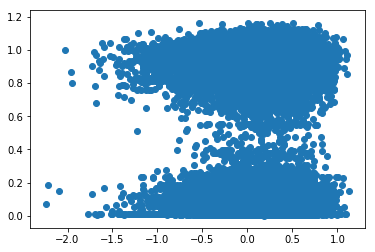

In [835]:
plt.scatter(fitnesses_vs_wt, sarkisyan['quantitative_function'][1:sample_size])

In [825]:
reshaped_fit_sarkisyan[0].reshape(digit_size, sequence_size).T

AttributeError: 'Tensor' object has no attribute 'T'